In [8]:
import numpy as np
import pandas as pd
import datajoint as dj
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

In [26]:
MODE = "online"
if MODE == "online":
    ratinfo = dj.create_virtual_module("intfo", "ratinfo")
    
    ANIMALS =  ["R501" , "Y501", "Y502", "Y514", "W600", "W511",]
    
    Mass_keys = [{"ratname": animal} for animal in ANIMALS]
    mass_df = pd.DataFrame((ratinfo.Mass & Mass_keys).fetch(as_dict=True))
    mass_df.drop(mass_df[mass_df['mass'] == 0].index, inplace=True)
    mass_df.to_csv("mass.csv", index=False)
    
if MODE == "offline":
    mass_df = pd.read_csv("mass.csv")

In [11]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 3 to 1171
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   mass      1098 non-null   object         
 1   weighing  1098 non-null   int64          
 2   date      1098 non-null   object         
 3   ratname   1098 non-null   object         
 4   tech      1098 non-null   object         
 5   timeval   1098 non-null   timedelta64[ns]
dtypes: int64(1), object(4), timedelta64[ns](1)
memory usage: 60.0+ KB


In [12]:
summary_df = mass_df.groupby("ratname").date.min().reset_index()
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["min_weight"] = summary_df["ratname"].map(
    mass_df.query("mass > 0").groupby("ratname").mass.min()
)

summary_df["max_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.max()
)

### Calculate baseline weight- minimum date

In [23]:
# Convert the columns to numeric data type if needed
mass_df['mass'] = pd.to_numeric(mass_df['mass'], errors='coerce')

baseline_df = mass_df.groupby('ratname').agg({'date': 'min', 'mass': 'first'}).reset_index()
baseline_df.columns = ['ratname', 'min_date', 'min_date_mass']

mass_df = pd.merge(mass_df, baseline_df, on='ratname', how='left')
mass_df["min_date_relative"] = (mass_df['mass'] / mass_df['min_date_mass']).round(2)

summary_df["min_date_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").min_date_mass.min()
)

mass_df['min_date_diff'] = mass_df.groupby('ratname')['min_date_relative'].diff()



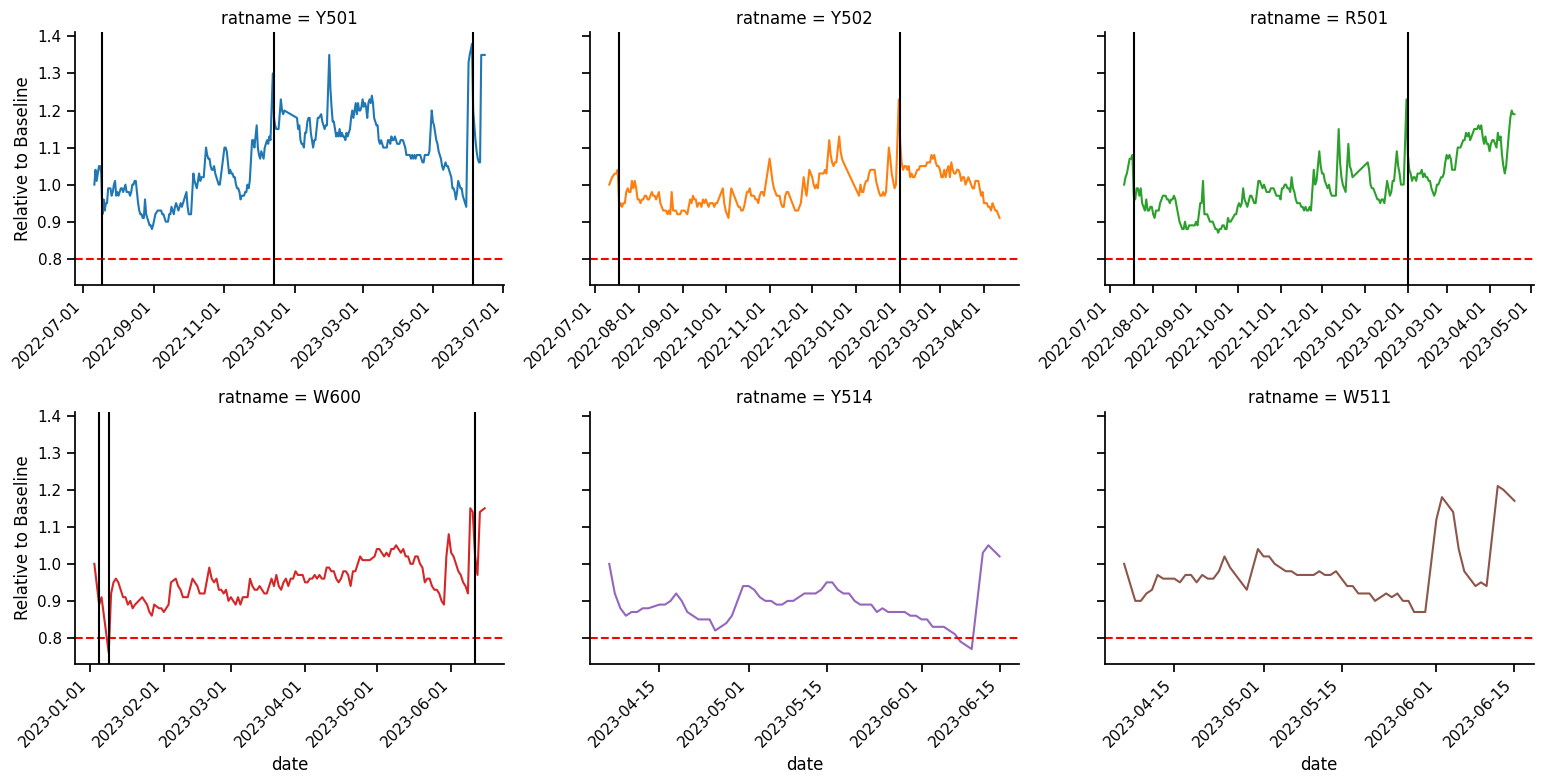

In [24]:
# Create the facet grid plot
g = sns.FacetGrid(
    data=mass_df, 
    col="ratname", 
    col_wrap=3, 
    hue="ratname", 
    height=4,
    sharex=False,
    aspect=1.3,
)
g.map(sns.lineplot, "date", "min_date_relative")
g.map(plt.axhline, y=0.80, color="red", linestyle="--")
g.set_xticklabels(rotation=45, ha='right')
# g.set_xticklabels()
g.fig.tight_layout()
g.set_axis_labels(y_var= "Relative to Baseline")

# plot a vertical line every time there is more than a 10% drop day-to-day
for ax, ratname in zip(g.axes.flat, g.col_names):
    filtered_df = mass_df[mass_df['ratname'] == ratname]
    for _, row in filtered_df[filtered_df['min_date_diff'] < -0.10].iterrows():
        ax.axvline(x=row['date'], color='black')



Possible ideas:
* what was the first training day for the above animals?
* could there be a window of time that's more appropriate than the first day? Ie first 7 masses?

In [25]:
mass_df.head(20)

,mass,weighing,date,ratname,tech,timeval,min_date,min_date_mass,min_date_relative,min_date_diff
0,20.82,1078539,2022-07-11,Y501,JW,0 days 15:07:09,2022-07-11,20.82,1.00,NaN
1,25.60,1078542,2022-07-11,Y502,JW,0 days 15:08:55,2022-07-11,25.60,1.00,NaN
2,23.28,1078543,2022-07-11,R501,JW,0 days 15:10:23,2022-07-11,23.28,1.00,NaN
3,23.71,1078767,2022-07-12,R501,JW,0 days 09:47:33,2022-07-11,23.28,1.02,0.02
4,25.97,1078775,2022-07-12,Y502,JW,0 days 09:50:18,2022-07-11,25.60,1.01,0.01
5,21.56,1078779,2022-07-12,Y501,JW,0 days 09:51:54,2022-07-11,20.82,1.04,0.04
6,23.91,1078996,2022-07-13,R501,JW,0 days 10:22:59,2022-07-11,23.28,1.03,0.01
7,21.03,1079002,2022-07-13,Y501,JW,0 days 10:26:23,2022-07-11,20.82,1.01,-0.03
8,26.04,1079003,2022-07-13,Y502,JW,0 days 10:26:40,2022-07-11,25.60,1.02,0.01
9,24.83,1079439,2022-07-15,R501,JL,0 days 13:27:25,2022-07-11,23.28,1.07,0.04
